# 2.3A Izbira modela za strojno učenje

V koraku izbira modela za strojno učenje:
- uvozimo podatke pridobljene v koraku 2. s katerih bomo učili modele
- podatke o strukturah molekule pretvorimo v fingerprinte (bitni zapis strukture, s tem dobimo featurje na X osi)
- izberemo kombinacijo najbolj primernega fingerprinta, klasifikatorja, vzorčenjske tehnike, skalarja, tehnike za zaznavanje outlierjev

# Uvoz knjižnic in splošnih funkcij

In [1]:
%run __A_knjiznice.py

from __A_knjiznice import *
from __B_funkcije import *
import __C_konstante as kon
%matplotlib inline

# Uvoz obdelanih podatkov obdelanih v koraku 2. Obdelava in analiza podatkov

## Pregled podatkov

We are limited to max 4142 samples. The sample size is quite small but we are limited to exisitng data. 

Two rules of thumb are often considered when we estimate the size of training set.

1. Rule-of-Thumb for Prediction Classes
The first rule suggests having a sample size at least 50 to 1000 times the number of prediction classes. Since we're dealing with binary classification (2 classes), this guideline would technically require a minimum of 100 to 2000 samples. With 4250 samples, we comfortably exceed the lower end of this range, suggesting that, from the perspective of prediction classes alone, our sample size is adequate.
2. Rule-of-Thumb for Observations vs. Features
The more challenging guideline in our case is the one suggesting having at least 20 times the number of observations as features. With up to 4860 features in case of certain fingerprints, this rule would imply you need around 100.000 observations, a number far exceeding our current sample size. This guideline is particularly important in machine learning to avoid overfitting, where a model learns the noise in the training data instead of the actual signal, leading to poor generalization to new data.

In order to be as close as possible to the second rule, I decidet to exclude fingerprints which have more than 1024 features, because fingerprints with +1024 features could lead to overfiting



In [2]:
df = pd.read_csv(f'{kon.path_files}/dp.csv')
df

,Smiles,ROMol,Activity
0,O=C1c2cc([N+](=O)[O-])ccc2-n2c1nc1ccccc1c2=O,<rdkit.Chem.rdchem.Mol object at 0x16fce49e0>,1
1,Cc1cc(C2CC2)ncc1-c1ccc(C2(C(=O)Nc3ccc(F)cc3)CO...,<rdkit.Chem.rdchem.Mol object at 0x16fcb09e0>,1
2,O=C(Nc1ccc(C2(C(=O)Nc3ccc(F)cc3)COC2)cc1)c1ccc...,<rdkit.Chem.rdchem.Mol object at 0x16fcdcba0>,1
3,O=C(Nc1ccc(F)cc1)C1(C2CCC3C(CCCN3c3ccnc(C(F)(F...,<rdkit.Chem.rdchem.Mol object at 0x16fcddcb0>,1
4,O=C1CC(c2c[nH]c3ccc(F)cc23)C(=O)N1,<rdkit.Chem.rdchem.Mol object at 0x16fce25e0>,1
...,...,...,...
4137,FC(F)(F)c1ccc(-c2c[nH]nn2)cc1,<rdkit.Chem.rdchem.Mol object at 0x16fcbef10>,0
4138,c1ccc2[nH]nnc2c1,<rdkit.Chem.rdchem.Mol object at 0x16fcf54d0>,0
4139,Cc1cccc(NC(=O)C(F)(F)F)c1-c1c[nH]nn1,<rdkit.Chem.rdchem.Mol object at 0x16fcb5230>,0
4140,Cc1ccc(N)cc1-c1c[nH]nn1,<rdkit.Chem.rdchem.Mol object at 0x16fcb2500>,0


In [3]:
activity_counts = df['Activity'].value_counts()
print(activity_counts)

Activity
1    2103
0    2039
Name: count, dtype: int64


# 3.3 Izračun relevantnih metrik za model strojnega učenja

## Test different fingerprints

**standard**: Considers paths of a given length. These are hashed fingerprints, with a default length of 1024.
**extended**: Similar to the standard type, but takes rings and atomic properties into account into account.
**graph**: Similar to the standard type by simply considers connectivity.
**hybridization**: Similar to the standard type, but only consider hybridization state.
**estate**: 79 bit fingerprints corresponding to the E-State atom types described by Hall and Kier.
**cdk-atompairs**: CDK's implementation of the atompairs fingerprint
**cdk-substructure**: CDK substructure fingerprint, basically identical to openbabel's fp4.
**pubchem**: 881 bit fingerprints defined by PubChem.
**klekota-roth**: 4860 bit fingerprint defined by Klekota and Roth.
**shortestpath**: A fingerprint based on the shortest paths between pairs of atoms and takes into account ring systems, charges etc.
**rdk-descriptor**: Various molecular descriptors implemented and calculated by RDKit.
**circular**: An implementation of the ECFP6 fingerprint.
**lingo**: An implementation of the LINGO fingerprint.
**rdkit**: Another implementation of a Daylight-like fingerprint by RDKit.
**maccs**: The popular 166 bit MACCS keys described by MDL.
**avalon**: Substructure or similarity Avalon fingerprint.
**atom-pair**: RDKit Atom-Pair fingerprint.
**topological-torsion**: RDKit Topological-Torsion Fingerprint.
**morgan**: RDKit Morgan fingerprint.
**fp2**: OpenBabel FP2 fingerprint, which indexes small molecule fragments based on linear segments of up to 7 atoms in length.
**fp3**: OpenBabel FP3 fingerprint, which is a fingerprint method created from a set of SMARTS patterns defining functional groups.
**fp4**: OpenBabel FP4 fingerprint, which is a fingerprint method created from a set of SMARTS patterns defining functional groups.
**spectrophore** Openbabel implementation of the spectrophore fingerprint (https://github.com/silicos-it/spectrophore).
**mol2vec**: Unsupervised machine learning approach for mulecule representation.

# Pregled kombinacij izbranih fingerprintov in klasifikacijskih modelov

## V tem koraku bi rad preveril katera kombinacija fingerprinta in klasifikacijskega modela je najboljša preden začnem manipulirati s podatki. Ta korak je pomemben zato da v nadaljnih korakih vidim kaj izboljšujem

In [4]:
# https://medium.com/artificialis/why-how-we-split-train-valid-and-test-fb4d6746ede

In [5]:
input_directory = f'{kon.path_files}/molekulski_prstni_odtisi'

generated_fingerprints = [
    'df_rdk-maccs.csv', 'df_maccs.csv', 'df_atom-pair.csv', 'df_extended.csv',
    'df_graph.csv', 'df_shortestpath.csv', 'df_fp2.csv', 'df_standard.csv',
    'df_hybridization.csv', 'df_rdkit.csv', 'df_circular.csv', 'df_avalon.csv',
    'df_morgan.csv'
]

In [6]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import pandas as pd
import os

# Define classifiers with random_state for reproducibility
classifiers = [
    ('rf', RandomForestClassifier(n_jobs=-1, random_state=kon.random_seed)),
    ('et', ExtraTreesClassifier(n_jobs=-1, random_state=kon.random_seed)),
    ('lr', LogisticRegression(max_iter=1000, random_state=kon.random_seed)),
    ('xgb', XGBClassifier(eval_metric='logloss', n_jobs=-1, random_state=kon.random_seed))
]

# Stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=kon.random_seed)
scoring = {'accuracy': 'accuracy', 'f1': 'f1', 'precision': 'precision', 'recall': 'recall', 'roc_auc': 'roc_auc'}
results_list = []  # To store detailed results
cv_results_list = []  # To store cross-validation results for box plots

# List of specific filenames to process
for filename in generated_fingerprints:
    file_path = os.path.join(input_directory, filename)
    
    if os.path.exists(file_path):  # Check if the file exists
        print(f'Processing fingerprint DataFrame: {filename}')
        
        df = pd.read_csv(file_path)
        fingerprint_name = filename.split('df_')[1].split('.')[0]
        y = df[['Activity']].values.ravel()  # Assuming 'Activity' is the target
        X = df.iloc[:, 3:]  # Assuming features start from the 4th column

        # Split the data into train, validation, and test sets
        X_interim, X_test, y_interim, y_test = train_test_split(X, y, test_size=0.15, random_state=kon.random_seed, shuffle=True, stratify=y)
        X_train, X_val, y_train, y_val = train_test_split(X_interim, y_interim, test_size=15/85, random_state=kon.random_seed, shuffle=True, stratify=y_interim)

        # Train and evaluate each classifier
        for clf_name, classifier in classifiers:
            print(f"Training {clf_name}...")

            # Cross-validation
            cv_results = cross_validate(classifier, X_train, y_train, cv=cv, scoring=scoring)

            # Store cross-validation results for box plots
            cv_results_list.append((fingerprint_name, clf_name, cv_results['test_accuracy']))  # Store accuracy scores for box plot

            # Fit the classifier
            classifier.fit(X_train, y_train)

            # Predict and evaluate on training data
            y_train_pred = classifier.predict(X_train)

            # Calculate training scores
            train_accuracy = accuracy_score(y_train, y_train_pred)
            train_f1 = f1_score(y_train, y_train_pred)
            train_precision = precision_score(y_train, y_train_pred)
            train_recall = recall_score(y_train, y_train_pred)
            train_roc_auc = roc_auc_score(y_train, y_train_pred)

            # Predict and evaluate on validation data
            y_val_pred = classifier.predict(X_val)

            val_accuracy = accuracy_score(y_val, y_val_pred)
            val_f1 = f1_score(y_val, y_val_pred)
            val_precision = precision_score(y_val, y_val_pred)
            val_recall = recall_score(y_val, y_val_pred)
            val_roc_auc = roc_auc_score(y_val, y_val_pred)

            # Store the results
            results_temp = {
                'Fingerprint': fingerprint_name,
                'Classifier': clf_name,
                'CV_Mean_Accuracy': cv_results['test_accuracy'].mean(),
                'CV_Mean_F1': cv_results['test_f1'].mean(),
                'CV_Mean_Precision': cv_results['test_precision'].mean(),
                'CV_Mean_Recall': cv_results['test_recall'].mean(),
                'CV_Mean_ROC_AUC': cv_results['test_roc_auc'].mean(),
                'Train_Accuracy': train_accuracy,
                'Train_F1': train_f1,
                'Train_Precision': train_precision,
                'Train_Recall': train_recall,
                'Train_ROC_AUC': train_roc_auc,
                'Val_Accuracy': val_accuracy,
                'Val_F1': val_f1,
                'Val_Precision': val_precision,
                'Val_Recall': val_recall,
                'Val_ROC_AUC': val_roc_auc,
            }

            results_list.append(results_temp)
            print("\nResults:")
            print(results_temp)

# Store all results in a DataFrame
results_df = pd.DataFrame(results_list)
print("\nFinal Results:")

Processing fingerprint DataFrame: df_rdk-maccs.csv
Training rf...

Results:
{'Fingerprint': 'rdk-maccs', 'Classifier': 'rf', 'CV_Mean_Accuracy': 0.8757654217873763, 'CV_Mean_F1': 0.8790198454098224, 'CV_Mean_Precision': 0.8696483503248384, 'CV_Mean_Recall': 0.8891937856223571, 'CV_Mean_ROC_AUC': 0.9279132193870625, 'Train_Accuracy': 0.9775707384403036, 'Train_F1': 0.9780331192970598, 'Train_Precision': 0.9724462365591398, 'Train_Recall': 0.9836845683208701, 'Train_ROC_AUC': 0.9774764817778142, 'Val_Accuracy': 0.8520900321543409, 'Val_F1': 0.8593272171253823, 'Val_Precision': 0.8313609467455622, 'Val_Recall': 0.8892405063291139, 'Val_ROC_AUC': 0.8514829982625961}
Training et...

Results:
{'Fingerprint': 'rdk-maccs', 'Classifier': 'et', 'CV_Mean_Accuracy': 0.8674871733683333, 'CV_Mean_F1': 0.8701722003782253, 'CV_Mean_Precision': 0.8665189260319851, 'CV_Mean_Recall': 0.8749172642029786, 'CV_Mean_ROC_AUC': 0.9073810141088814, 'Train_Accuracy': 0.9775707384403036, 'Train_F1': 0.97759393312

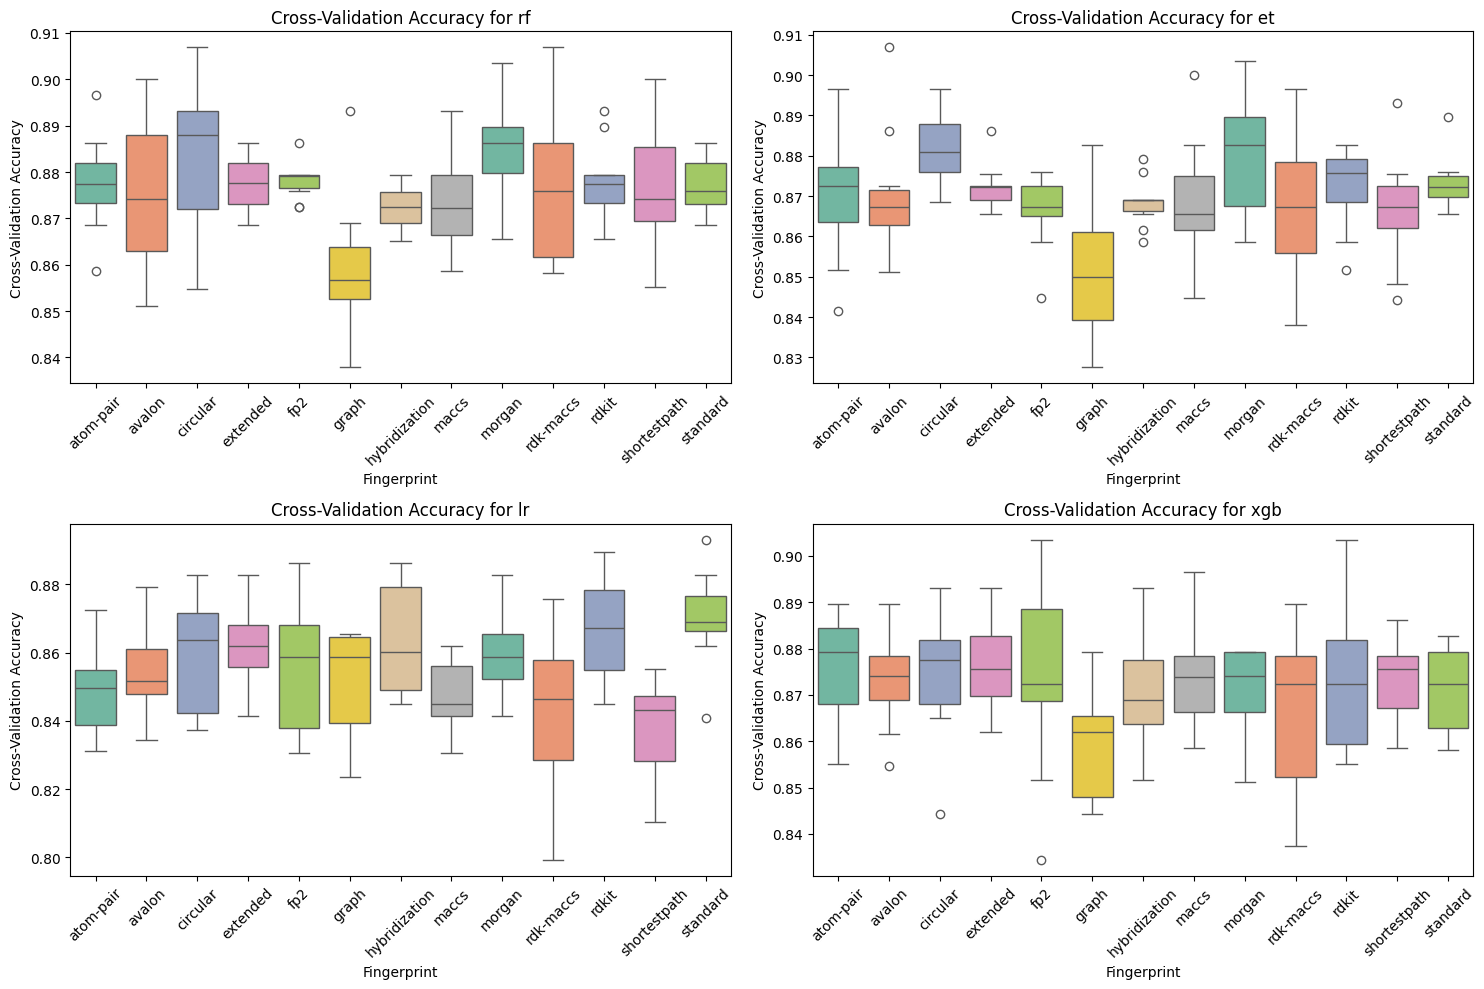

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame for cross-validation accuracy scores
cv_results_df = pd.DataFrame(cv_results_list, columns=['Fingerprint', 'Classifier', 'CV_Accuracy'])

# Explode the CV_Accuracy column to have one accuracy score per row
cv_results_df = cv_results_df.explode('CV_Accuracy')

# Get the unique fingerprints in alphabetical order
fingerprint_order = sorted(cv_results_df['Fingerprint'].unique())

# Convert 'Fingerprint' to a categorical type with the specified order
cv_results_df['Fingerprint'] = pd.Categorical(cv_results_df['Fingerprint'], categories=fingerprint_order, ordered=True)

# Create a color mapping for fingerprints in alphabetical order
palette = sns.color_palette("Set2", n_colors=len(fingerprint_order))
color_mapping = {fingerprint: palette[i] for i, fingerprint in enumerate(fingerprint_order)}

# Plotting Cross-Validation Accuracy
plt.figure(figsize=(15, 10))

# Create a box plot for each classifier
for i, (clf_name, _) in enumerate(classifiers):
    plt.subplot(2, 2, i + 1)  # Create a 2x2 grid of subplots
    sns.boxplot(data=cv_results_df[cv_results_df['Classifier'] == clf_name], 
                 x='Fingerprint', 
                 y='CV_Accuracy', 
                 hue='Fingerprint',  # Set hue to Fingerprint for color differentiation
                 palette=color_mapping,  # Use the color mapping
                 legend=False)  # Disable the legend if not needed
    plt.title(f'Cross-Validation Accuracy for {clf_name}')
    plt.xticks(rotation=45)  # Rotate x labels for better readability
    plt.ylabel('Cross-Validation Accuracy')
    plt.xlabel('Fingerprint')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

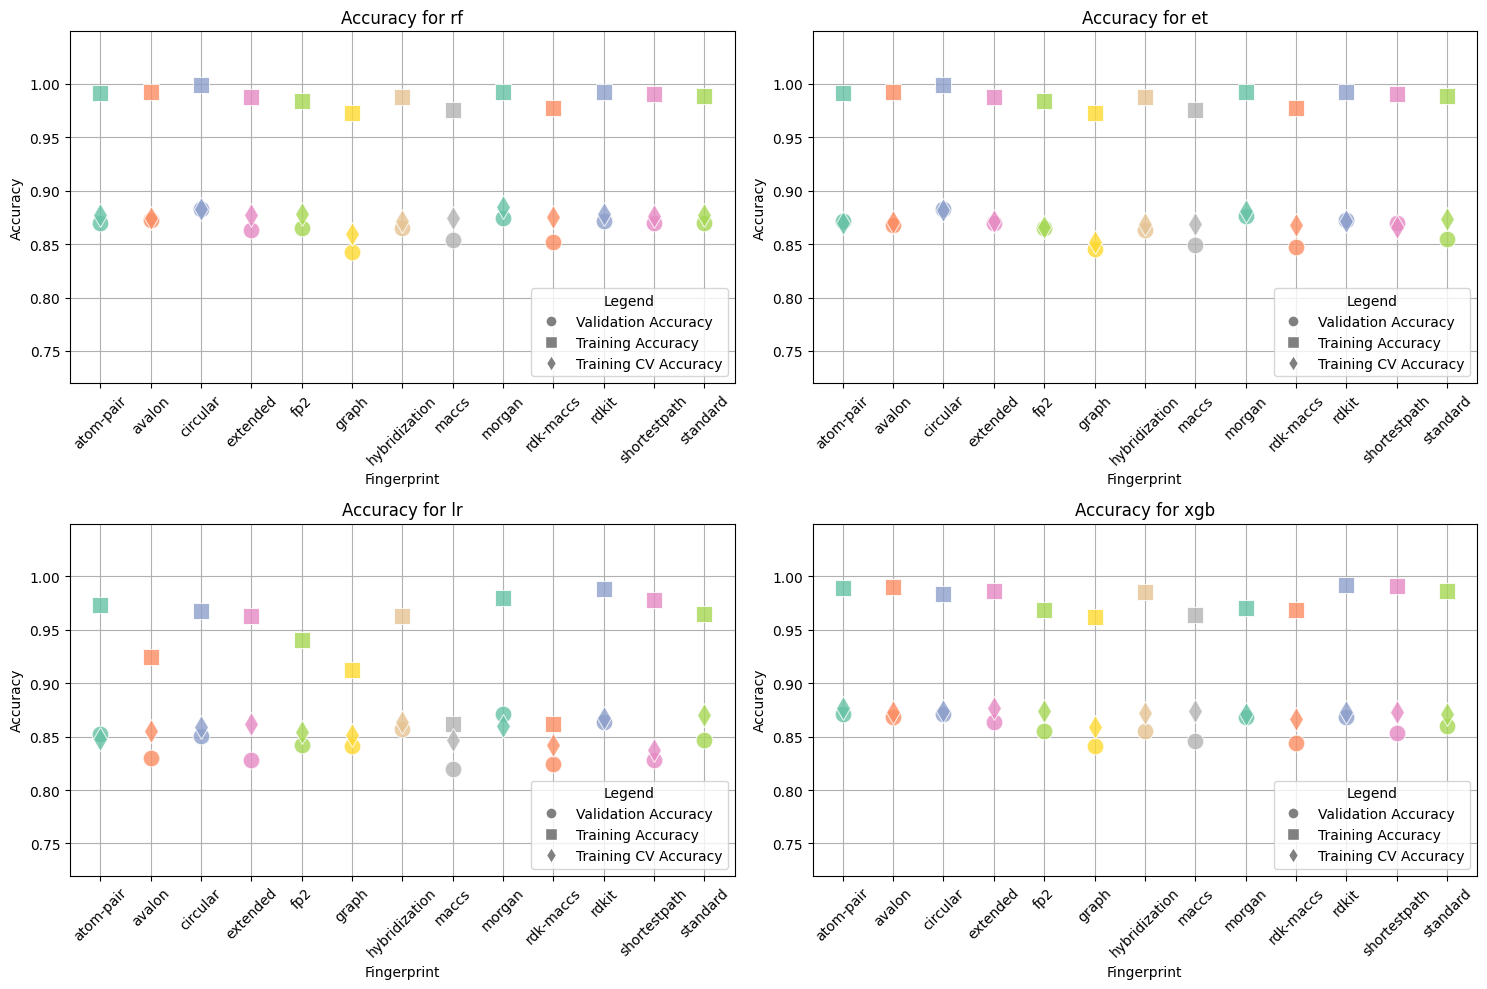

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.lines import Line2D

# Assuming results_df is already defined and contains both Val_Accuracy and Train_Accuracy
val_results_df = results_df  # Using the existing results_df

# Get the unique fingerprints in alphabetical order
fingerprint_order = sorted(val_results_df['Fingerprint'].unique())

# Convert 'Fingerprint' to a categorical type with the specified order
val_results_df['Fingerprint'] = pd.Categorical(val_results_df['Fingerprint'], categories=fingerprint_order, ordered=True)

# Create a color mapping for fingerprints
palette = sns.color_palette("Set2", n_colors=len(fingerprint_order))
color_mapping = {fingerprint: palette[i] for i, fingerprint in enumerate(fingerprint_order)}

# Create a figure for the subplots
plt.figure(figsize=(15, 10))

# Create a line plot for each classifier in the specified order
for i, (clf_name, _) in enumerate(classifiers):
    plt.subplot(2, 2, i + 1)  # Create a 2x2 grid of subplots
    
    # Plot Validation Accuracy
    sns.lineplot(data=val_results_df[val_results_df['Classifier'] == clf_name], 
                 x='Fingerprint', 
                 y='Val_Accuracy', 
                 hue='Fingerprint',  # Differentiate by fingerprint
                 palette=color_mapping,  # Use the color mapping for fingerprints
                 marker='o',  # Circle marker for validation
                 markersize=12,  # Increased marker size
                 alpha=0.8,  # Set transparency for better visibility
                 legend=False)  # Disable the legend
    
    # Plot Training Accuracy
    sns.lineplot(data=val_results_df[val_results_df['Classifier'] == clf_name], 
                 x='Fingerprint', 
                 y='Train_Accuracy',  # Use Train_Accuracy instead of Test_Accuracy
                 hue='Fingerprint',  # Differentiate by fingerprint
                 palette=color_mapping,  # Use the same color mapping
                 marker='s',  # Square marker for training
                 markersize=12,  # Increased marker size
                 alpha=0.8,  # Set transparency for better visibility
                 legend=False)  # Disable the legend

    # Plot Training Accuracy
    sns.lineplot(data=val_results_df[val_results_df['Classifier'] == clf_name], 
                 x='Fingerprint', 
                 y='CV_Mean_Accuracy',  # Use Train_Accuracy instead of Test_Accuracy
                 hue='Fingerprint',  # Differentiate by fingerprint
                 palette=color_mapping,  # Use the same color mapping
                 marker='d',  # Square marker for training
                 markersize=12,  # Increased marker size
                 alpha=0.8,  # Set transparency for better visibility
                 legend=False)  # Disable the legend
    
    plt.xticks(rotation=45)  # Rotate x labels for better readability
    plt.ylabel('Accuracy')
    plt.xlabel('Fingerprint')
    plt.title(f'Accuracy for {clf_name}')
    
    # Set y-axis limits based on the accuracy data
    plt.ylim(min(val_results_df['Val_Accuracy'].min(), val_results_df['Train_Accuracy'].min()) - 0.1, 
             max(val_results_df['Val_Accuracy'].max(), val_results_df['Train_Accuracy'].max()) + 0.05)
    plt.grid(True)  # Add grid for better readability

    # Add individual legends for each subplot
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=8, label='Validation Accuracy'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='gray', markersize=8, label='Training Accuracy'),
        Line2D([0], [0], marker='d', color='w', markerfacecolor='gray', markersize=8, label='Training CV Accuracy'),
    ]
    plt.legend(handles=legend_elements, loc='lower right', title='Legend')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [9]:
results_df

,Fingerprint,Classifier,CV_Mean_Accuracy,CV_Mean_F1,CV_Mean_Precision,CV_Mean_Recall,CV_Mean_ROC_AUC,Train_Accuracy,Train_F1,Train_Precision,Train_Recall,Train_ROC_AUC,Val_Accuracy,Val_F1,Val_Precision,Val_Recall,Val_ROC_AUC
0,rdk-maccs,rf,0.875765,0.879020,0.869648,0.889194,0.927913,0.977571,0.978033,0.972446,0.983685,0.977476,0.852090,0.859327,0.831361,0.889241,0.851483
1,rdk-maccs,et,0.867487,0.870172,0.866519,0.874917,0.907381,0.977571,0.977594,0.991608,0.963970,0.977780,0.847267,0.852255,0.837920,0.867089,0.846943
2,rdk-maccs,lr,0.842629,0.848152,0.832899,0.864709,0.903153,0.861629,0.866289,0.850131,0.883073,0.861298,0.824759,0.832565,0.808955,0.857595,0.824222
3,rdk-maccs,xgb,0.866100,0.869275,0.862884,0.876949,0.932023,0.968944,0.969595,0.963734,0.975527,0.968843,0.844051,0.852807,0.819242,0.889241,0.843313
4,maccs,rf,0.874392,0.877501,0.868914,0.887158,0.928909,0.975845,0.976271,0.973631,0.978926,0.975798,0.853698,0.858476,0.844037,0.873418,0.853376
5,maccs,et,0.868525,0.870676,0.869472,0.872876,0.908214,0.975845,0.975845,0.990890,0.961251,0.976070,0.848875,0.852665,0.844720,0.860759,0.848680
6,maccs,lr,0.846782,0.852016,0.836455,0.868790,0.908509,0.861974,0.866667,0.850229,0.883753,0.861638,0.819936,0.826625,0.809091,0.844937,0.819527
7,maccs,xgb,0.873704,0.876636,0.869184,0.885126,0.935409,0.964113,0.964983,0.955971,0.974167,0.963958,0.845659,0.851852,0.831325,0.873418,0.845206
8,atom-pair,rf,0.877499,0.879875,0.876649,0.883761,0.937875,0.991718,0.991875,0.987862,0.995921,0.991654,0.869775,0.873239,0.863777,0.882911,0.869560
9,atom-pair,et,0.869913,0.872228,0.869291,0.875598,0.929988,0.991718,0.991798,0.997251,0.986404,0.991800,0.871383,0.874214,0.868750,0.879747,0.871246


In [10]:
results_df.sort_values(by=['Val_Accuracy'], ascending=False, inplace = True)
results_df

,Fingerprint,Classifier,CV_Mean_Accuracy,CV_Mean_F1,CV_Mean_Precision,CV_Mean_Recall,CV_Mean_ROC_AUC,Train_Accuracy,Train_F1,Train_Precision,Train_Recall,Train_ROC_AUC,Val_Accuracy,Val_F1,Val_Precision,Val_Recall,Val_ROC_AUC
40,circular,rf,0.883009,0.885053,0.884078,0.886459,0.941378,0.999310,0.999320,0.999320,0.999320,0.999310,0.882637,0.885400,0.878505,0.892405,0.882477
41,circular,et,0.881983,0.883917,0.883038,0.885103,0.941109,0.999310,0.999320,1.000000,0.998640,0.999320,0.882637,0.884676,0.883281,0.886076,0.882580
49,morgan,et,0.880945,0.883432,0.878966,0.888514,0.933515,0.992754,0.992830,0.997257,0.988443,0.992820,0.876206,0.877971,0.879365,0.876582,0.876200
48,morgan,rf,0.884396,0.887417,0.878205,0.897357,0.940450,0.992754,0.992889,0.989204,0.996601,0.992694,0.874598,0.878125,0.867284,0.889241,0.874359
37,rdkit,et,0.871982,0.874593,0.869319,0.880350,0.921503,0.992063,0.992142,0.997253,0.987084,0.992140,0.872990,0.875197,0.873817,0.876582,0.872932
44,avalon,rf,0.874727,0.878711,0.865268,0.893280,0.935187,0.992409,0.992542,0.989858,0.995241,0.992365,0.872990,0.876755,0.864615,0.889241,0.872725
50,morgan,lr,0.860241,0.864675,0.850682,0.879665,0.925802,0.979641,0.979925,0.980926,0.978926,0.979652,0.871383,0.875776,0.859756,0.892405,0.871039
36,rdkit,rf,0.878190,0.881009,0.873919,0.888523,0.933750,0.992063,0.992206,0.989189,0.995241,0.992014,0.871383,0.874214,0.868750,0.879747,0.871246
9,atom-pair,et,0.869913,0.872228,0.869291,0.875598,0.929988,0.991718,0.991798,0.997251,0.986404,0.991800,0.871383,0.874214,0.868750,0.879747,0.871246
11,atom-pair,xgb,0.876462,0.878706,0.876066,0.881720,0.939400,0.988958,0.989116,0.989789,0.988443,0.988966,0.871383,0.873016,0.875796,0.870253,0.871401


In [11]:
results_df.head(20)

,Fingerprint,Classifier,CV_Mean_Accuracy,CV_Mean_F1,CV_Mean_Precision,CV_Mean_Recall,CV_Mean_ROC_AUC,Train_Accuracy,Train_F1,Train_Precision,Train_Recall,Train_ROC_AUC,Val_Accuracy,Val_F1,Val_Precision,Val_Recall,Val_ROC_AUC
40,circular,rf,0.883009,0.885053,0.884078,0.886459,0.941378,0.999310,0.999320,0.999320,0.999320,0.999310,0.882637,0.885400,0.878505,0.892405,0.882477
41,circular,et,0.881983,0.883917,0.883038,0.885103,0.941109,0.999310,0.999320,1.000000,0.998640,0.999320,0.882637,0.884676,0.883281,0.886076,0.882580
49,morgan,et,0.880945,0.883432,0.878966,0.888514,0.933515,0.992754,0.992830,0.997257,0.988443,0.992820,0.876206,0.877971,0.879365,0.876582,0.876200
48,morgan,rf,0.884396,0.887417,0.878205,0.897357,0.940450,0.992754,0.992889,0.989204,0.996601,0.992694,0.874598,0.878125,0.867284,0.889241,0.874359
37,rdkit,et,0.871982,0.874593,0.869319,0.880350,0.921503,0.992063,0.992142,0.997253,0.987084,0.992140,0.872990,0.875197,0.873817,0.876582,0.872932
44,avalon,rf,0.874727,0.878711,0.865268,0.893280,0.935187,0.992409,0.992542,0.989858,0.995241,0.992365,0.872990,0.876755,0.864615,0.889241,0.872725
50,morgan,lr,0.860241,0.864675,0.850682,0.879665,0.925802,0.979641,0.979925,0.980926,0.978926,0.979652,0.871383,0.875776,0.859756,0.892405,0.871039
36,rdkit,rf,0.878190,0.881009,0.873919,0.888523,0.933750,0.992063,0.992206,0.989189,0.995241,0.992014,0.871383,0.874214,0.868750,0.879747,0.871246
9,atom-pair,et,0.869913,0.872228,0.869291,0.875598,0.929988,0.991718,0.991798,0.997251,0.986404,0.991800,0.871383,0.874214,0.868750,0.879747,0.871246
11,atom-pair,xgb,0.876462,0.878706,0.876066,0.881720,0.939400,0.988958,0.989116,0.989789,0.988443,0.988966,0.871383,0.873016,0.875796,0.870253,0.871401


In [12]:
# Get top 3 distinct fingerprints and convert to list
top_fingerprints = results_df['Fingerprint'].drop_duplicates().head(3).tolist()

# Get top 3 distinct classifiers and convert to list
top_classifiers = results_df['Classifier'].drop_duplicates().head(3).tolist()

# Results
print("Top Distinct Fingerprints:")
print(top_fingerprints)
print("\nTop Distinct Classifiers:")
print(top_classifiers)

Top Distinct Fingerprints:
['circular', 'morgan', 'rdkit']

Top Distinct Classifiers:
['rf', 'et', 'lr']


In [13]:
# Define output directory
output_dir = f'{kon.path_files}/model_SU'

# Convert lists to DataFrames
fingerprints_df = pd.DataFrame(top_fingerprints, columns=['Fingerprint'])
classifiers_df = pd.DataFrame(top_classifiers, columns=['Classifier'])

# Save DataFrames to CSV
fingerprints_df.to_csv(f'{output_dir}/top_fingerprints.csv', index=False)
classifiers_df.to_csv(f'{output_dir}/top_classifiers.csv', index=False)